# Image segmentation

suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level.

Image segmentation has many applications in **medical imaging**, **self-driving cars** and **satellite imaging** to name a few.


## dataset:
The dataset that will be used for this tutorial is the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi et al. The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories :

* Class 1 : Pixel belonging to the pet.
* Class 2 : Pixel bordering the pet.
* Class 3 : None of the above/ Surrounding pixel.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from IPython.display import clear_output
import matplotlib.pyplot as plt
from keras.losses import SparseCategoricalCrossentropy

In [73]:
#Download the Oxford-IIIT Pets dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*',shuffle_files=True , with_info=True)
#The segmentation masks are included in version 3+.

In [74]:
#standardization
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1 #convert cls number to {0, 1, 2}
  return input_image, input_mask

In [75]:
#Compiles a function into a callable TensorFlow graph.
@tf.function
#data augmentation

def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (224, 224))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (224, 224))

  # data augmentation
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [76]:
#transform for test data
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (224, 224))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (224, 224))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [77]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
dataset.keys()

dict_keys(['train', 'test'])

In [78]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [79]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [80]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

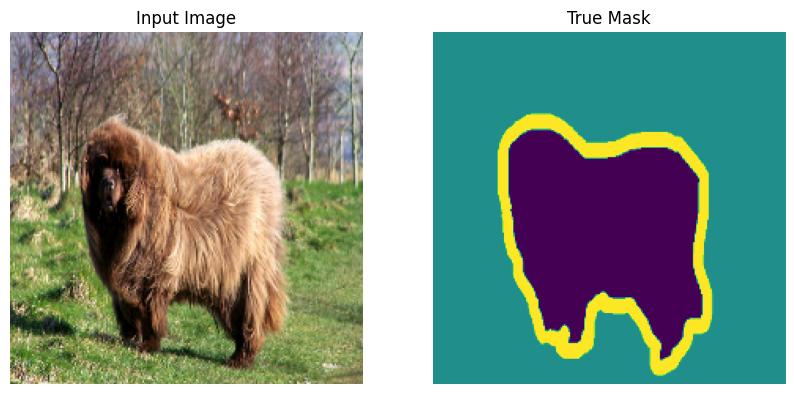

In [82]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Define the model
In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose outputs will be used, and the decoder will be the upsample block.

In [83]:
OUTPUT_CHANNELS = 3

In [84]:
from keras.applications import MobileNetV3Large, ResNet50, MobileNetV2
from keras import Model, layers, losses, utils
base_model = MobileNetV2(input_shape=[224, 224, 3], include_top=False, weights="imagenet", pooling="max")

# Use the activations of these layers
layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [85]:
down_stack.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_6[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.



In [86]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [87]:
from keras.layers import Input, Concatenate, Conv2DTranspose
from keras import regularizers
def unet_model(output_channels):

  inputs = Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = Concatenate() # take an object
    x = concat([x, skip])

  # This is the last layer of the model
  last = Conv2DTranspose(
      OUTPUT_CHANNELS, 3, strides=2,
      padding='same',  #64x64 -> 128x128
      activation='silu',
      #kernel_initializer="he_uniform",
      kernel_regularizer=regularizers.L2(0.001),
  )

  x = last(x)

  return Model(inputs=inputs, outputs=x)

In [88]:
import keras
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.91, beta_2=0.998),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model_5 (Functional)        [(None, 112, 112, 96),       1841984   ['input_7[0][0]']             
                              (None, 56, 56, 144),                                                
                              (None, 28, 28, 192),                                                
                              (None, 14, 14, 576),                                                
                              (None, 7, 7, 320)]                                                  
                                                                                            

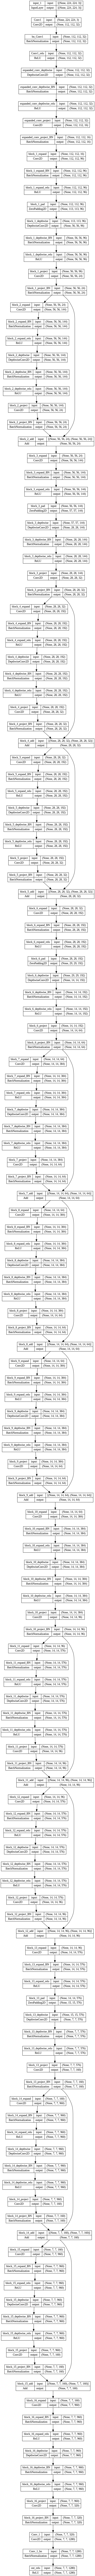

In [17]:
utils.plot_model(base_model, show_shapes=True)

Let's try out the model to see what it predicts before training.



In [89]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [90]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 888ms/step


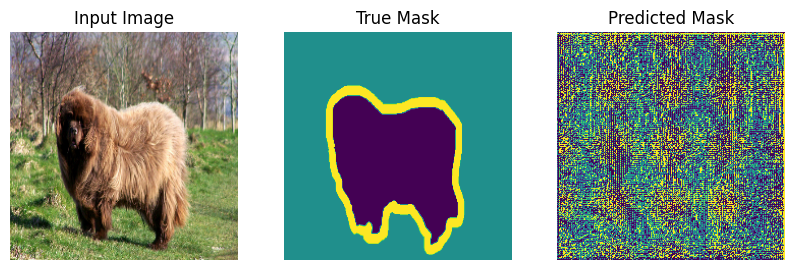

In [91]:
show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below.



In [92]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 24ms/step


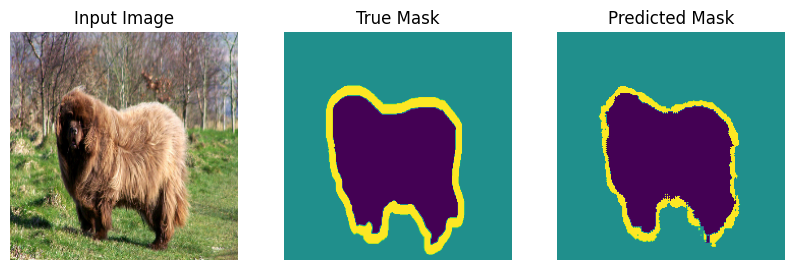


Sample Prediction after epoch 20

57/57 [==============================] - 24s 413ms/step - loss: 0.2778 - accuracy: 0.9189 - val_loss: 0.3525 - val_accuracy: 0.8963


In [93]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          verbose = 1,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

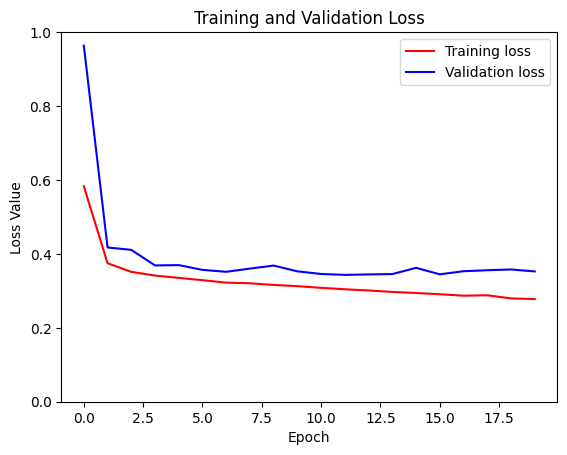

In [94]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

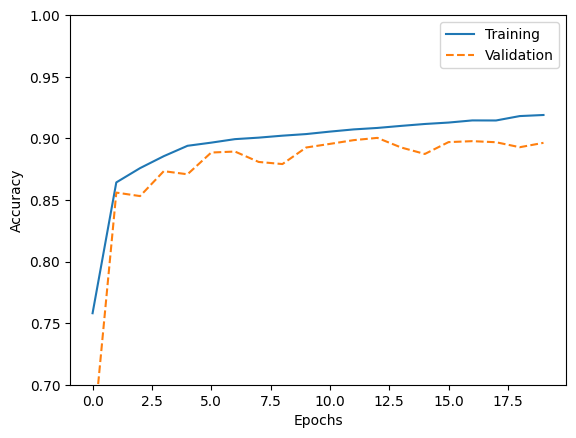

In [95]:
history_1 = model_history.history
acc=history_1['accuracy']
val_acc = history_1['val_accuracy']

plt.plot(acc[:150], '-', label='Training')
plt.plot(val_acc[:150], '--', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.7,1.0])
plt.legend()
plt.show()

### Make predictions

2/2 [==============================] - 0s 130ms/step


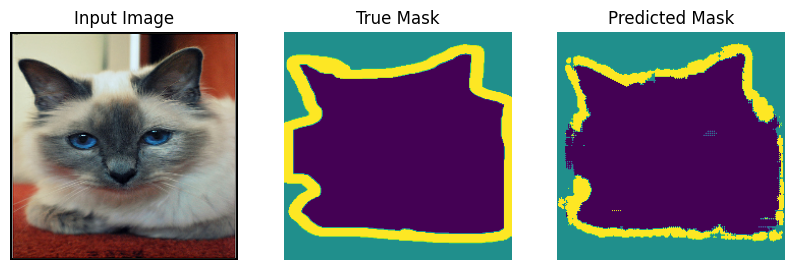

2/2 [==============================] - 0s 85ms/step


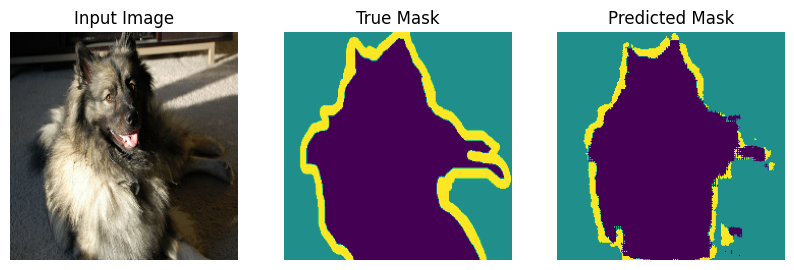

2/2 [==============================] - 0s 84ms/step


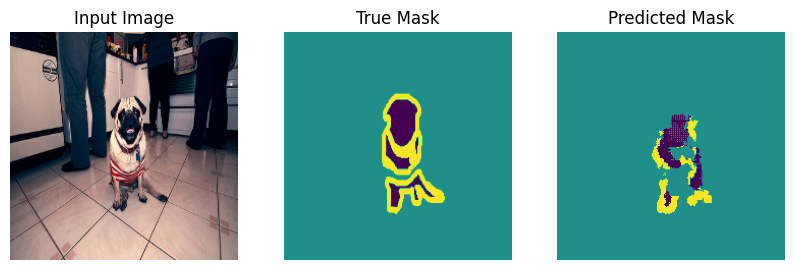

2/2 [==============================] - 0s 86ms/step


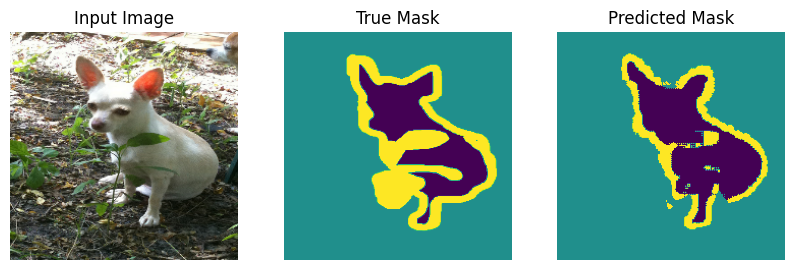

2/2 [==============================] - 0s 72ms/step


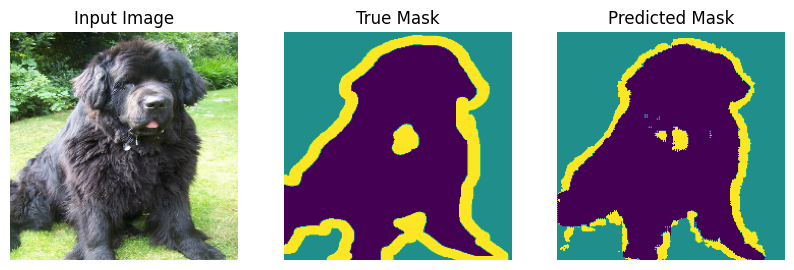

In [96]:
show_predictions(test_dataset, 5)